<a href="https://colab.research.google.com/github/himanshuv62/Mlops-project/blob/main/Gender_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deploy a classification model to categorize a user's gender.**



#**Importing Necessary Libraries**

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from google.colab import drive
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



#**Data Ingestion**

In [ ]:
flight_df=pd.read_csv("/content/drive/MyDrive/travel_capstone/flights.csv",on_bad_lines='skip')
hotel_df=pd.read_csv("/content/drive/MyDrive/travel_capstone/hotels.csv",on_bad_lines='skip')
user_df=pd.read_csv("/content/drive/MyDrive/travel_capstone/users.csv",on_bad_lines='skip')

In [ ]:
flight_df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


In [ ]:
hotel_df.head()

,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019


In [ ]:
user_df.head()

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


#**Data Preprocessing**

##**Userdf**

In [ ]:
#check for missing values
user_df.isnull().sum()

code       0
company    0
name       0
gender     0
age        0
dtype: int64

In [ ]:
#check for duplicate rows
user_df.duplicated().sum()

0

In [ ]:
#check for data types of different features
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     1340 non-null   int64 
 1   company  1340 non-null   object
 2   name     1340 non-null   object
 3   gender   1340 non-null   object
 4   age      1340 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.5+ KB


1. gender feature is our dependent feature,we will encode the categorical values in this feature i.e male and female using label encoder,to fetch it into our classification model for training.1 denotes male and 0 denotes female.

2. Similarly we will encode values in company features using label encoder.

3. On name feature we will use NLP model such as sentence transformer and use pca technique,before fetching it for buliding the classification model.


In [ ]:
# 5 Point Summary of numerical features
user_df.describe()

,code,age
count,1340.000000,1340.000000
mean,669.500000,42.742537
std,386.968991,12.869779
min,0.000000,21.000000
25%,334.750000,32.000000
50%,669.500000,42.000000
75%,1004.250000,54.000000
max,1339.000000,65.000000


In [ ]:
user_df['company'].value_counts()

4You             453
Acme Factory     261
Wonka Company    237
Monsters CYA     195
Umbrella LTDA    194
Name: company, dtype: int64

In [ ]:
user_df.head()

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


In [ ]:
user_df[user_df['name']=='Charlotte Johnson']

,code,company,name,gender,age
316,316,4You,Charlotte Johnson,female,64
496,496,Monsters CYA,Charlotte Johnson,none,51


In [ ]:
# Summary of categorical features
user_df.describe(include=object)

,company,name,gender
count,1340,1340,1340
unique,5,1338,3
top,4You,Charlotte Johnson,male
freq,453,2,452


1. As we see ,we have 3 categories in our target variable ,let's deep dive into the target variable.


In [ ]:
user_df['gender'].value_counts()

male      452
female    448
none      440
Name: gender, dtype: int64

In [ ]:
#filtering records based on relavent categories in the target variable
user_df1=user_df[(user_df['gender']=='male') | (user_df['gender']=='female') ]

In [ ]:
# Encode userCode and company to numeric values
label_encoder = LabelEncoder()

user_df1['company_encoded'] = label_encoder.fit_transform(user_df1['company'])
user_df1['gender_encoded'] = label_encoder.fit_transform(user_df1['gender'])



In [ ]:
user_df1.head()

,code,company,name,gender,age,company_encoded,gender_encoded
0,0,4You,Roy Braun,male,21,0,1
1,1,4You,Joseph Holsten,male,37,0,1
2,2,4You,Wilma Mcinnis,female,48,0,0
3,3,4You,Paula Daniel,female,23,0,0
4,4,4You,Patricia Carson,female,44,0,0


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Initialize the SentenceTransformer model
model = SentenceTransformer('flax-sentence-embeddings/all_datasets_v4_MiniLM-L6')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Encode text-based columns and create embeddings
text_columns = ['name']

for column in text_columns:
    user_df1[column + '_embedding'] = user_df1[column].apply(lambda text: model.encode(text))

# Concatenate the embeddings into a single feature vector
text_embeddings = user_df1[text_columns].values.tolist()

In [ ]:
#  Apply PCA separately to each text embedding column
n_components = 23  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
text_columns = ['name']
# Create an empty array to store the PCA-transformed embeddings
text_embeddings_pca = np.empty((len(user_df1), n_components * len(text_columns)))

for i, column in enumerate(text_columns):
    embeddings = user_df1[column + '_embedding'].values.tolist()
    embeddings_pca = pca.fit_transform(embeddings)
    text_embeddings_pca[:, i * n_components:(i + 1) * n_components] = embeddings_pca

numerical_features=['code','company_encoded','age']


X_numerical = user_df1[numerical_features].values

# Combine PCA-transformed text embeddings and numerical features
X = np.hstack((text_embeddings_pca, X_numerical))
# Target variable
y = user_df1['gender_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
len(text_embeddings)

900

In [ ]:
print("Shape of X:", X.shape)

Shape of X: (900, 26)


In [ ]:
user_df1[numerical_features].values

array([[   0,    0,   21],
       [   1,    0,   37],
       [   2,    0,   48],
       ...,
       [1337,    3,   28],
       [1338,    3,   52],
       [1339,    3,   35]])

#**Logistic Regression**

Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96        77
           1       0.95      0.99      0.97       103

    accuracy                           0.97       180
   macro avg       0.97      0.96      0.97       180
weighted avg       0.97      0.97      0.97       180



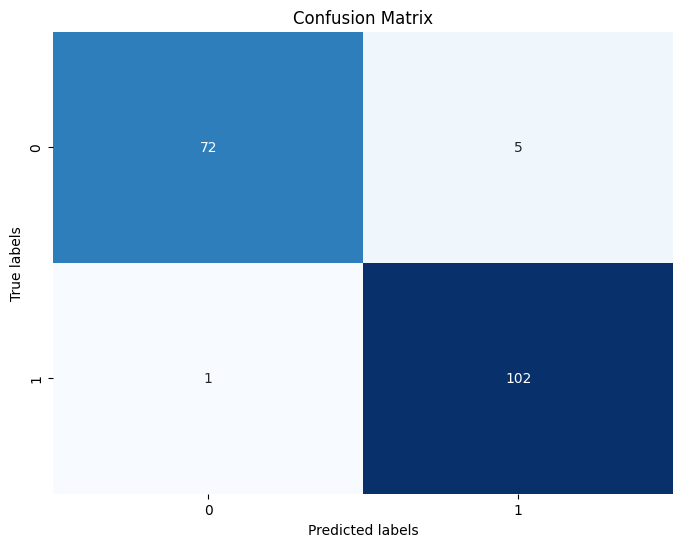

In [ ]:
# Initialize a Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42)

# Fit the model to the training data
lr_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = lr_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_lr)
print("\nClassification Report:\n", report)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
lr_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = lr_classifier.predict(X_train)
y_val_pred = lr_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")


Training Accuracy: 0.9722222222222222
Validation Accuracy: 0.9666666666666667
The model is overfitting.


In [ ]:
model_result = pd.DataFrame([['Logistic Regression Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])

model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.972222,0.966667


#**Decision Tree Classifier**

Accuracy: 0.9555555555555556

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        77
           1       0.96      0.96      0.96       103

    accuracy                           0.96       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.96      0.96      0.96       180



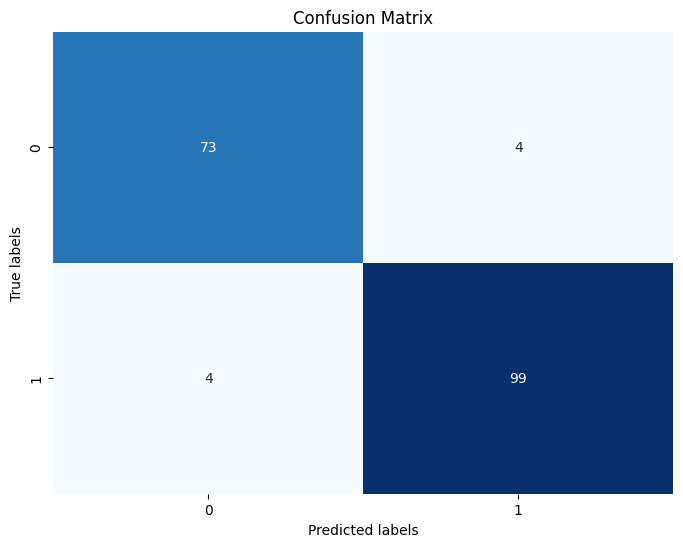

In [ ]:
# Initialize a Random Forest Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = dt_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_dt)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
dt_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = dt_classifier.predict(X_train)
y_val_pred = dt_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Validation Accuracy: 0.9555555555555556
The model is overfitting.


In [ ]:
model = pd.DataFrame([['Decesion Tree Classifier Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.972222,0.966667
1,Decesion Tree Classifier Baseline,1.000000,0.955556


#**Random Forest Classifier**

In [ ]:
# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

###**Evaluation**

Accuracy: 0.9833333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        77
           1       0.98      0.99      0.99       103

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



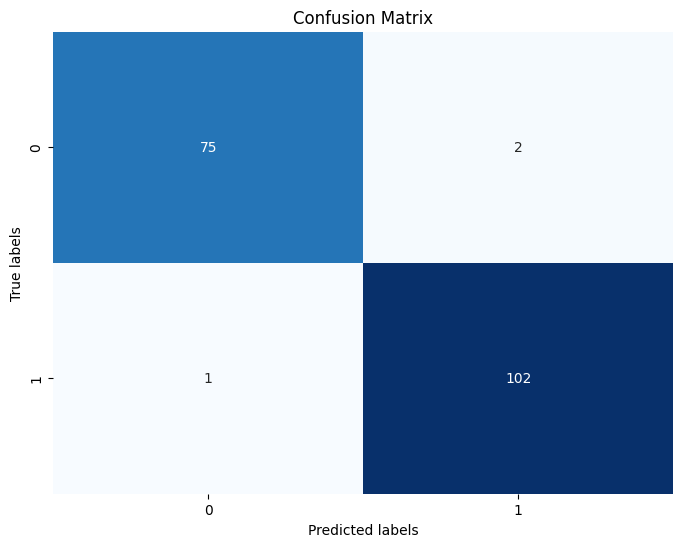

In [ ]:
# Calculate and print accuracy
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_rf)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = rf_classifier.predict(X_train)
y_val_pred = rf_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Validation Accuracy: 0.9833333333333333
The model is overfitting.


In [ ]:
model = pd.DataFrame([['Random Forest Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.972222,0.966667
1,Decesion Tree Classifier Baseline,1.000000,0.955556
2,Random Forest Baseline,1.000000,0.983333


#**Gradient Boosting Classifier**

Accuracy: 0.9722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97        77
           1       0.97      0.98      0.98       103

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



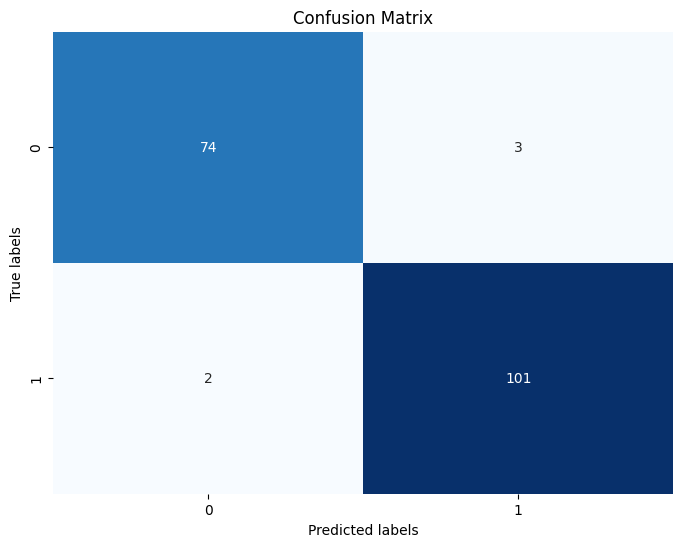

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)


# Fit the model to the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gb = gb_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = gb_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_gb)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
gb_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = gb_classifier.predict(X_train)
y_val_pred = gb_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Validation Accuracy: 0.9722222222222222
The model is overfitting.


In [ ]:
model = pd.DataFrame([['XGBoost Classifier Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.972222,0.966667
1,Decesion Tree Classifier Baseline,1.000000,0.955556
2,Random Forest Baseline,1.000000,0.983333
3,XGBoost Classifier Baseline,1.000000,0.972222


#**ROC-AUC Curve**

Now.... RF
Now.... GB
Now.... DT
Now.... Logistic Regression


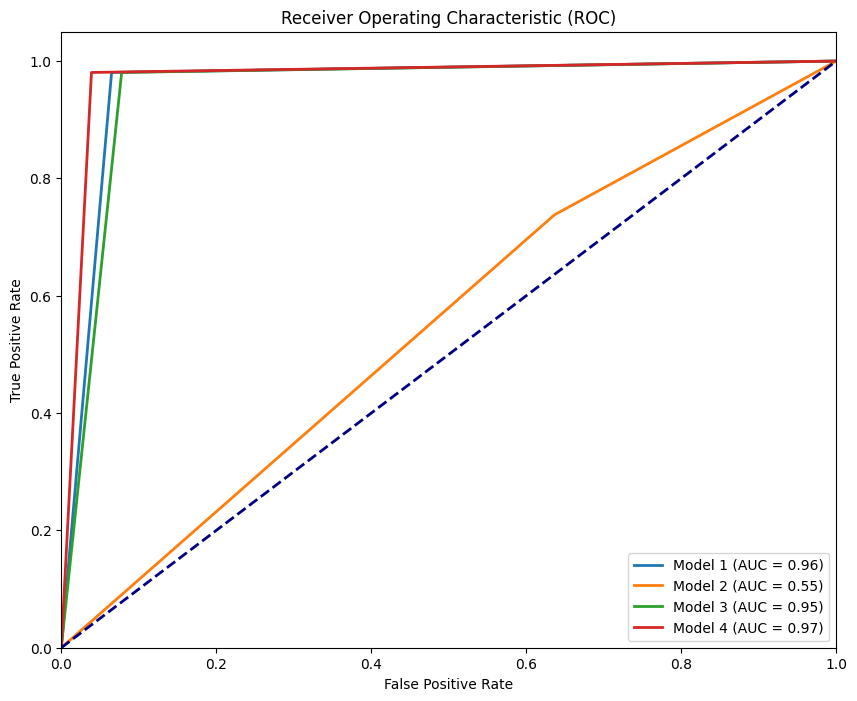

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model
    report = classification_report(y_test, y_pred)

    # Print accuracy and classification report
    #print(f"\nAccuracy for {model_name}: {accuracy:.2f}")
    #print(f"Classification Report for {model_name}:\n{report}")

    # Return accuracy and classification report
    return report

# Initialize models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(random_state=42)


# Create a dictionary to store the classification reports
model_reports = {}

# Train and evaluate each model
print("Now.... RF")
model_reports['Random Forest'] = train_and_evaluate_model(random_forest, X_train, y_train, X_test, y_test, 'Random Forest')
print("Now.... GB")
model_reports['Gradient Boosting'] = train_and_evaluate_model(gradient_boosting, X_train, y_train, X_test, y_test, 'Gradient Boosting')
print("Now.... DT")
model_reports['Decision Tree'] = train_and_evaluate_model(decision_tree, X_train, y_train, X_test, y_test, 'Decision Tree')
print("Now.... Logistic Regression")
model_reports['Logistic Regression'] = train_and_evaluate_model(logistic_regression, X_train, y_train, X_test, y_test, 'Logistic Regression')


# Save the classification reports to a CSV file
reports_df = pd.DataFrame.from_dict(model_reports, orient='index', columns=['Classification Report'])
reports_df.to_csv('classification_reports.csv')

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are lists or arrays containing true labels and predicted probabilities for each model

# Initialize lists to store fpr, tpr, and roc_auc for each model
fpr_list = []
tpr_list = []
roc_auc_list = []

# Compute ROC curve and ROC AUC for each model
for y_pred in [y_pred_lr,y_pred_dt,y_pred_rf,y_pred_gb]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for i, roc_auc in enumerate(roc_auc_list):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'Model {i+1} (AUC = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()







#**Benchmark Model Selection and Hyperparameter Tuning**

**Logistic Regression is our Benchmark model**

Best Hyperparameters: {'C': 4, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Model Accuracy: 0.9555555555555556

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        77
           1       0.95      0.97      0.96       103

    accuracy                           0.96       180
   macro avg       0.96      0.95      0.95       180
weighted avg       0.96      0.96      0.96       180



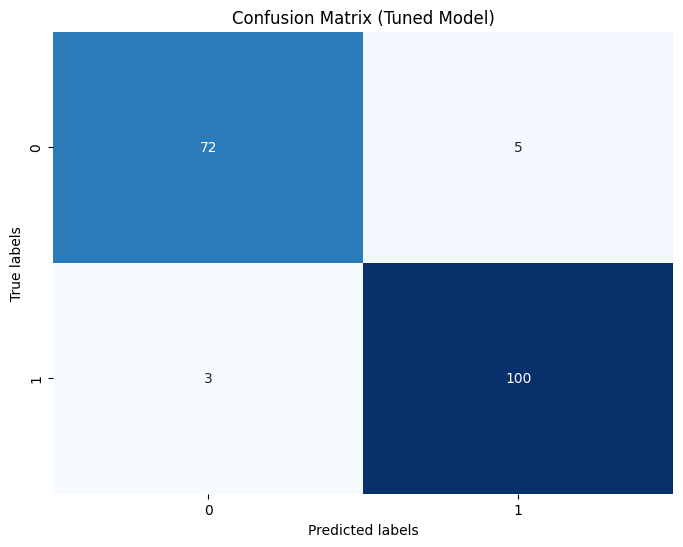

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 4, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize a Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(lr_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model found by GridSearchCV
best_lr_classifier = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_lr_tuned = best_lr_classifier.predict(X_test)

# Calculate and print accuracy using the best model
accuracy_tuned = best_lr_classifier.score(X_test, y_test)
print("Tuned Model Accuracy:", accuracy_tuned)

# Generate a classification report using the tuned model
report_tuned = classification_report(y_test, y_pred_lr_tuned)
print("\nTuned Model Classification Report:\n", report_tuned)

# Calculate confusion matrix using the tuned model
cm_tuned = confusion_matrix(y_test, y_pred_lr_tuned)

# Plot confusion matrix using the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
best_lr_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = best_lr_classifier.predict(X_train)
y_val_pred = best_lr_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)



Training Accuracy: 0.9763888888888889
Validation Accuracy: 0.9555555555555556


#**Pickle the Benchmark model**

In [ ]:
import pickle

# Pickle the tuned logistic regression model
with open('tuned_logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_lr_classifier, file)


In [ ]:
# Pickle the Scaler model
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
# Pickle the PCA model
with open('pca.pkl', 'wb') as file:
    pickle.dump(pca, file)